<a href="https://colab.research.google.com/github/jscienciadados/ciencia-dados/blob/main/Word2vec_Usando_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="DarkSlateBlue">Machine Learning</font># 

#<font color="DarkSlateGray">Processamento de Linguagem Natural</font>


O Word2vec é uma rede neural de duas camadas que processa o texto “vetorizando” as
palavras. Sua entrada é um corpus de texto e sua saída é um conjunto de vetores; vetores de
recursos que representam palavras nesse corpus. Embora o Word2vec não seja uma rede
neural profunda, ele transforma o texto em uma forma numérica que as redes neurais
profundas podem entender.
O Word2vec é um método de calcular representações vetoriais de palavras e foi
desenvolvido por uma equipe de pesquisadores do Google liderada por Tomas Mikolov. O
Google hospeda uma versão de código aberto do Word2vec lançada sob uma licença Apache
2.0. Em 2014, Mikolov deixou o Google para o Facebook e, em maio de 2015, foi concedida ao
Google uma patente para o método, que não revoga a licença do Apache sob a qual foi lançado.
Aqui o paper original:
https://arxiv.org/pdf/1301.3781.pdf


#<font color="Chocolate">Estudo de Caso</font>

#<font color="DarkMagenta">Similaridade de Cosseno</font>
Entre diferentes métricas de distância, a similaridade de cosseno é mais intuitiva e mais
usada no Word2vec. É um produto normalizado de 2 vetores e essa relação define o ângulo
entre eles. Dois vetores com a mesma orientação têm uma similaridade de cosseno de 1, dois
vetores a 90 ° têm uma similaridade de 0 e dois vetores diametralmente opostos têm uma
similaridade de -1, independentemente de sua magnitude.
Uma vez que as palavras são representadas por vetores, a tarefa de encontrar palavras
semelhantes ou diferentes torna-se mais fácil. Quaisquer combinações de vetores resultam em
um novo vetor e as distâncias do cosseno ou outras medidas de similaridade podem ser usadas.
É assim que resolvemos a famosa equação que define o Word2vec:
'rei - homem + mulher = rainha'
Com um modelo Word2vec, conseguimos associar palavras com base no seu contexto,
usando nossa boa e velha Matemática.


In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())


Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.10


In [2]:
!pip install -q -U watermark

In [3]:
!pip install scikit-plot

In [4]:
# Imports
import torch
import scipy
import sklearn
import scikitplot
import numpy as np
import torch.nn.functional as F
from torch.optim import SGD
from torch.autograd import Variable, profiler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from scikitplot.decomposition import plot_pca_2d_projection
%matplotlib inline


In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Word2vec - PCA" --iversions


Author: Word2vec - PCA

IPython   : 5.5.0
torch     : 1.8.1+cu101
scikitplot: 0.3.7
scipy     : 1.4.1
numpy     : 1.19.5
sklearn   : 0.0



# Preparação dos Dados

In [6]:
# Corpus
corpus = ['ele é um rei',
          'ela é uma rainha',
          'ele é um homem',
          'ela é uma mulher',
          'Madrid é a capital da Espanha',
          'Berlim é a capital da Alemanha',
          'Lisboa é a capital de Portugal']


In [7]:
# Construindo o vocabulário com tokenização
palavras = []
for sentence in corpus:
    for palavra in sentence.split():
         if palavra not in palavras:
            palavras.append(palavra)


In [8]:
# visualiza
palavras

['ele',
 'é',
 'um',
 'rei',
 'ela',
 'uma',
 'rainha',
 'homem',
 'mulher',
 'Madrid',
 'a',
 'capital',
 'da',
 'Espanha',
 'Berlim',
 'Alemanha',
 'Lisboa',
 'de',
 'Portugal']

In [9]:
# Criamos o mapeamento palavra - índice  
word2idx = {w:idx for (idx, w) in enumerate(palavras)}
word2idx

{'Alemanha': 15,
 'Berlim': 14,
 'Espanha': 13,
 'Lisboa': 16,
 'Madrid': 9,
 'Portugal': 18,
 'a': 10,
 'capital': 11,
 'da': 12,
 'de': 17,
 'ela': 4,
 'ele': 0,
 'homem': 7,
 'mulher': 8,
 'rainha': 6,
 'rei': 3,
 'um': 2,
 'uma': 5,
 'é': 1}

In [10]:
# Criamos o mapeamento inverso índice - palavra
idx2word = {idx:w for (idx, w) in enumerate(palavras)}
idx2word

{0: 'ele',
 1: 'é',
 2: 'um',
 3: 'rei',
 4: 'ela',
 5: 'uma',
 6: 'rainha',
 7: 'homem',
 8: 'mulher',
 9: 'Madrid',
 10: 'a',
 11: 'capital',
 12: 'da',
 13: 'Espanha',
 14: 'Berlim',
 15: 'Alemanha',
 16: 'Lisboa',
 17: 'de',
 18: 'Portugal'}

In [11]:
# Tamanho do vocabulario
tamanho_vocab = len(word2idx)
tamanho_vocab

19

#<font color="DarkOrange">Construção do Modelo</font>

In [12]:
# Função para gerar os embeddings
def get_word_embedding(word):
    word_vec_one_hot = np.zeros(tamanho_vocab)
    word_vec_one_hot[word2idx[word]] = 1
    return word_vec_one_hot

In [13]:
# Função para gerar os vetores, da palavra central e do contexto
def gera_vetores():
    for sentence in corpus:
        words = sentence.split()
        indices = [word2idx[w] for w in words]
       
        # Loop pelo range de índices
        # Aqui geramos o vetor da palavra central em i
        # E geramos o vetor de contexto
        for i in range(len(indices)):
            for w in range(-window_size, window_size + 1):
                context_idx = i + w
                if context_idx < 0 or context_idx >= len(indices) or i == context_idx:
                    continue
                   
                # Gera os vetores    
                center_vec_one_hot = np.zeros(tamanho_vocab)
                center_vec_one_hot[indices[i]] = 1
                context_idx = indices[context_idx]
                               
                yield center_vec_one_hot, context_idx


In [14]:
# Hiperparametros
embedding_dims = 10
window_size = 2

#Definição dos pesos da rede neural.

W1 é uma matriz de pesos de dimensões embedding_dims x tamanho_vocab
W2 é uma matriz de pesos de dimensões tamanho_vocab x embedding_dims
Os pesos (ou coeficientes ou parâmetros) é aquilo que a rede aprende durante o treinamento. Como no início não sabemos qual o valor ideal de pesos (isso é o que queremos descobrir) iniciamos com valores randômicos usando torch.randn().

Ao final do aprendizado, o modelo em si nada mais é do que os valores ideais de W1 e W2.

In [15]:
# Definição dos pesos da rede neural
W1 = Variable(torch.randn(embedding_dims, tamanho_vocab).float(), requires_grad = True)
W2 = Variable(torch.randn(tamanho_vocab, embedding_dims).float(), requires_grad = True)

In [16]:
# Treinamento
print("\nIniciando o Treinamento...\n")
for epoch in range(1001):
   
    # Inicializa o erro médio da rede
    avg_loss = 0
   
    # Inicializa o controle do número de amostras
    samples = 0
   
    # Loop pelos dados (vetores de entrada)
    for data, target in gera_vetores():
       
        # Coleta x (vetor da palavra central)
        x = Variable(torch.from_numpy(data)).float()
       
        # Coleta y (vetor do contexto)
        y_true = Variable(torch.from_numpy(np.array([target])).long())
       
        # Atualiza o número de amostras
        samples += len(y_true)
       
        # Resultado da multiplicação entre os pesos e as primeiras camadas da rede
        a1 = torch.matmul(W1, x)
        a2 = torch.matmul(W2, a1)

        # A função softmax entrega a probabilidade da previsão da rede
        log_softmax = F.log_softmax(a2, dim = 0)

        # Previsão da rede
        network_pred_dist = F.softmax(log_softmax, dim = 0)
       
        # Calcula o erro, comparando a previsão da rede com o valor real
        # (como fazemos em qualquer modelo de aprendizagem supervisionada)
        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
       
        # Erro médio
        avg_loss += loss.item()
       
        # Inicia o backpropagation
        loss.backward()

        # Atualiza o valor dos pesos para a próxima passada
        W1.data -= 0.002 * W1.grad.data
        W2.data -= 0.002 * W2.grad.data

        # Zera o valor do gradiente depois de atualizar os pesos
        W1.grad.data.zero_()
        W2.grad.data.zero_()
       
    # Imprime o erro da rede
    if epoch % 10 == 0:
        print('Erro de Treinamento:', avg_loss / samples)

print("\nTreinamento Concluído.")



Iniciando o Treinamento...

Erro de Treinamento: 7.25364737054135
Erro de Treinamento: 5.297457513657022
Erro de Treinamento: 4.332893113506601
Erro de Treinamento: 3.753596453590596
Erro de Treinamento: 3.3729032997755293
Erro de Treinamento: 3.0980715824568525
Erro de Treinamento: 2.8860293113170785
Erro de Treinamento: 2.715951166729978
Erro de Treinamento: 2.576224444235893
Erro de Treinamento: 2.460086359147062
Erro de Treinamento: 2.363352782390219
Erro de Treinamento: 2.282710148774563
Erro de Treinamento: 2.2149107140746525
Erro de Treinamento: 2.156970256186546
Erro de Treinamento: 2.1065735458693604
Erro de Treinamento: 2.0621131149695273
Erro de Treinamento: 2.022497070121004
Erro de Treinamento: 1.986957165630574
Erro de Treinamento: 1.9549212931318487
Erro de Treinamento: 1.925938423009629
Erro de Treinamento: 1.8996348441281217
Erro de Treinamento: 1.8756930580798616
Erro de Treinamento: 1.853839639019459
Erro de Treinamento: 1.8338374761824912
Erro de Treinamento: 1.815

#<font color="Thistle">Teste do Modelo e Redução de Dimensionalidade com PCA</font>
Para testar o modelo, tudo que precisamos é dos pesos, em nosso exemplo W1 e W2. Mas visualizar os dados é desafiador, pois a dimensionalidade é alta e quanto maior o número de palavras do vocabulário, mais complicado.

Uma alternativa, é reduzir a diemensionalidade dos dados. Convertemos todos os atributos em 2 componentes principais usando PCA (Principal Component Analysis) e com 2 componentes podemos visualizar os dados.

Cada componentes principal nada mais é do que a junção matemática da informação em outras variáveis. O PCA é um algoritmo de Machine Learning por si mesmo, da categoria de aprendizagem não supervisionada.

Vamos aplicar o PCA para visualizar os dados.

In [17]:
# cria o objeto para redução de dimensionalidade
pca = PCA(n_components= 2)

In [18]:
# treina o modelo PCA
pca.fit(W1.data.numpy().T)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [19]:
# calcula a projeção PCA para o plot
proj = pca.transform(W1.data.numpy().T)

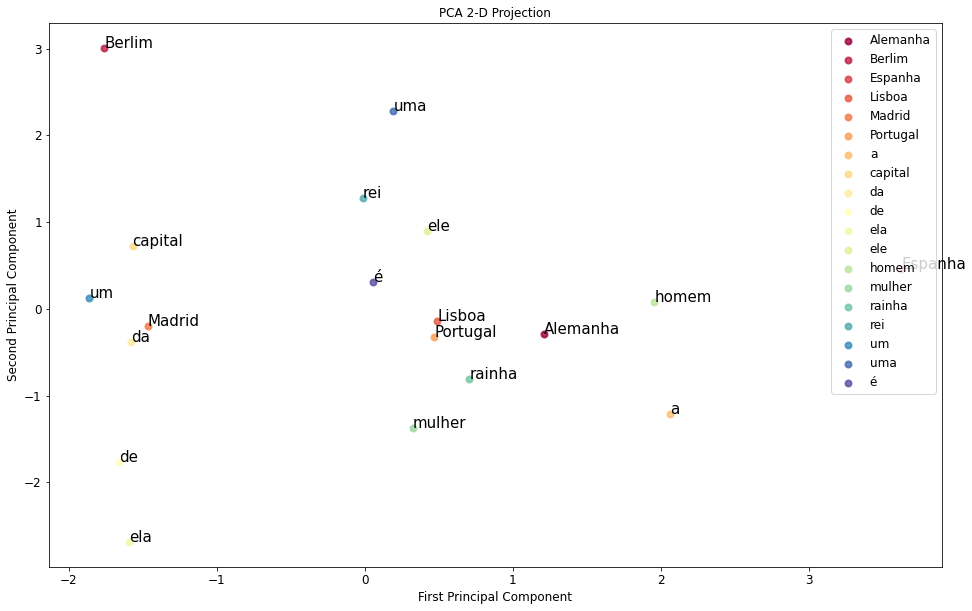

In [20]:
# Plot
ax = plot_pca_2d_projection(pca,
                            W1.data.numpy().T,
                            np.array(palavras),
                            feature_labels = palavras,
                            figsize = (16,10),
                            text_fontsize = 12)

# Legenda
for i, txt in enumerate(palavras):
    ax.annotate(txt, (proj[i,0], proj[i,1]), size = 15)


Observe a legenda no gráfico acima! Palavras similares com base no contexto, estão com a "bolinha" com cores parecidas. No topo da lista temos países e cidades, depois pronomes e a palavra "capital", temos então homem, mulher, rainha e rei e por fim artigos e um verbo.

Tudo isso foi aprendido pela rede com base no contexto, que nada mais é do que a distância de cosseno entre as embeddings, os vetores que representam as palavras.

A visualização acima mostra que palavras que estão na mesma direção possui alguma similaridade, por exemplo "Alemanha" e "Berlim". Passe uma linha reta imaginária que "corta" as palavras "Alemanha" e "Berlim". Consegue? Se a resposta for sim, as palavras são similares. Abaixo terá outro exemplo.

Vamos extrair as distâncias com base na pergunta:

Espanha está para Madrid, assim como Alemanha está para ?

Vamos perguntar ao modelo.

In [21]:
# Função para obter um vetor de palavras no peso W1 (esse é o contexto)
def get_word_vector_v(word):
    return W1[:, word2idx[word]].data.numpy()


In [22]:
# Função para obter um vetor de palavras no peso W2 (essa é a palavra central)
def get_word_vector_u(word):
    return W2[word2idx[word],:].data.numpy()


In [23]:
# Vamos obter os vetores das palavras
espanha = 1 * get_word_vector_v('Espanha') + 1 * get_word_vector_u('Espanha')
alemanha = 1 * get_word_vector_v('Alemanha') + 1 * get_word_vector_u('Alemanha')
madrid = 1 * get_word_vector_v('Madrid') + 1 * get_word_vector_u('Madrid') 


In [24]:
# Resultado
resultado = madrid - espanha + alemanha

In [25]:
# Este é o resultado, ou seja, uma embedding que representa a palavra mais similar à palavra "Alemanha",
# com base na similaridade (contexto) entre "Polônia" e "Varsóvia".
resultado

array([ 1.8882428 , -1.8212676 ,  1.3414304 , -1.0540638 , -2.0743103 ,
        0.05316627,  0.7175113 ,  0.6317148 ,  1.8789866 , -1.1368148 ],
      dtype=float32)

In [26]:
# Vamos extrair as distâncias de todas as outras palavras para a nossa palavra "secreta" que está
# no vetor embedding chamado "resultado"
# Usamos a função cosine() do SciPy para calcular as distâncias
distancias = [(v, cosine(resultado, 1 * get_word_vector_u(v) + 1 * get_word_vector_v(v))) for v in palavras]


In [27]:
# visualiza as distancias
distancias

[('ele', 1.1787219792604446),
 ('é', 1.3881038427352905),
 ('um', 1.0506029278039932),
 ('rei', 0.9289370030164719),
 ('ela', 0.9503111019730568),
 ('uma', 0.9104681685566902),
 ('rainha', 1.0405895486474037),
 ('homem', 1.6095991730690002),
 ('mulher', 0.7519820928573608),
 ('Madrid', 0.4813191890716553),
 ('a', 1.5527369379997253),
 ('capital', 0.9840819519013166),
 ('da', 1.0327985845506191),
 ('Espanha', 1.7278605103492737),
 ('Berlim', 0.8619408756494522),
 ('Alemanha', 0.9273734167218208),
 ('Lisboa', 1.605421543121338),
 ('de', 0.7532189935445786),
 ('Portugal', 0.8831573948264122)]

In [28]:
# Ordenando a lista de tuplas pelo segundo elemento da tupla
distancias.sort(key= lambda tup: tup[1])

In [29]:
distancias

[('Madrid', 0.4813191890716553),
 ('mulher', 0.7519820928573608),
 ('de', 0.7532189935445786),
 ('Berlim', 0.8619408756494522),
 ('Portugal', 0.8831573948264122),
 ('uma', 0.9104681685566902),
 ('Alemanha', 0.9273734167218208),
 ('rei', 0.9289370030164719),
 ('ela', 0.9503111019730568),
 ('capital', 0.9840819519013166),
 ('da', 1.0327985845506191),
 ('rainha', 1.0405895486474037),
 ('um', 1.0506029278039932),
 ('ele', 1.1787219792604446),
 ('é', 1.3881038427352905),
 ('a', 1.5527369379997253),
 ('Lisboa', 1.605421543121338),
 ('homem', 1.6095991730690002),
 ('Espanha', 1.7278605103492737)]

O vetor "resultado" foi uma previsão do nosso modelo e as palavras "Madrid" e "Berlim" são as mais similares. Observe que "Berlim" é a palavra mais similar com base no conexto, uma vez que Madrid já foi usada em nossa fórmula.

Imagine que um vetor (uma flecha) sai da origem do sistema de coordenadas (Honestidade = 0 e Experiência = 0, chamaremos de ponto O) e termina no ponto X. Este vetor é usado para localizar o ponto no nosso espaço de características. Não é diferente de simplesmente dizer que X possui H = 0.4 e E = 0.2, é apenas outra maneira de ver isso.



# Em que contexto aparece a palavra Lisboa?
Aqui é como se estivessemos usando o modelo para uma previsão.

In [30]:
# Extrai o contexto
context_to_predict = get_word_vector_v('Lisboa')

# Variável com o contexto a prever
hidden = Variable(torch.from_numpy(context_to_predict)).float()

# Executa o modelo e extrai as probabilidades
# (executar o modelo nada mais é do que multiplicar os novos dados de entrada pelos pesos aprendidos no treinamento)
a = torch.matmul(W2, hidden)
probs = F.softmax(a, dim = 0).data.numpy()

# Imprime o resultado
for context, prob in zip(palavras, probs):
    print(f'{context}: {prob}')


ele: 0.00016214001516345888
é: 0.4760536551475525
um: 0.009503720328211784
rei: 6.57345590298064e-05
ela: 0.0035811029374599457
uma: 0.0003836873220279813
rainha: 0.003099314868450165
homem: 0.008479798212647438
mulher: 4.420884943101555e-05
Madrid: 7.819833626854233e-06
a: 0.46125853061676025
capital: 0.005371751729398966
da: 0.006410080939531326
Espanha: 0.0057525006122887135
Berlim: 0.0005791796138510108
Alemanha: 0.0001633703213883564
Lisboa: 0.00029596342938020825
de: 0.0021264655515551567
Portugal: 0.0166610237210989


O contexto da palavra "Lisboa" é representado pelas palavras "é", "a", "Portugal".

Nosso modelo não conseguiu aprender o contexto "capital". Quem sabe você consegue otimizar o treinamento do modelo e aumentar sua precisão.

=> Este modelo pode ser melhorado.....